# Working with time series, frequency series, and unit conversion

In this notebook, we show some of the most useful features of the [timeseries](../series.rst) module. To do so, we will analyze a fake gravitational-wave signal. We will also show the [frequencyseries](../series.rst) module and the [unitconv](../unitconv.rst) modules.

First, let's generate this signal. 

(This notebook is meant to be converted in Sphinx documentation and not used directly.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from kuibit import timeseries as ts
from kuibit import series
from kuibit import unitconv as uc
from kuibit.gw_utils import luminosity_distance_to_redshift

%matplotlib inline

In [2]:
t = np.linspace(0, 20, 5000)
y = np.sin(t)

# Generate a TimeSeries by providing the times and the values of the series
gw = ts.TimeSeries(t, y)

To access the times and the values, use ``gw.t`` and ``gw.y``. You can also iterate over the series with a for loop yielding the elements `(t, y)` at each iteration of the loop. For example.

In [3]:
for tt, yy in gw:
    print(tt, yy)

0.0 0.0
0.004000800160032006 0.004000789486971321
0.008001600320064013 0.008001514935783532
0.012002400480096018 0.012002112309302542
0.016003200640128026 0.016002517572444287
0.020004000800160033 0.020002666693199687
0.024004800960192037 0.024002495643659576
0.028005601120224044 0.028001940401039562
0.03200640128025605 0.03200093694870479
0.03600720144028806 0.03599942127719461
0.040008001600320066 0.03999732938524717
0.04400880176035207 0.0439945972808238
0.048009601920384073 0.04799116098213332
0.05201040208041608 0.05198695651865616
0.05601120224044809 0.055981919932168285
0.060012002400480095 0.059975987277764924
0.0640128025605121 0.06396909462488413
0.0680136027205441 0.06796117805833003
0.07201440288057612 0.07195217367929596
0.07601520304060812 0.07594201760638712
0.08001600320064013 0.07993064597664322
0.08401680336067213 0.08391799494656059
0.08801760352070415 0.08790400069311417
0.09201840368073615 0.09188859941477902
0.09601920384076815 0.09587172733255157
0.10002000400080

0.4377143174506656
2.6925385077015402 0.4341136480752838
2.6965393078615723 0.43050603011164024
2.7005401080216043 0.426891521304641
2.7045409081816363 0.4232701795094896
2.7085417083416683 0.419642062690761
2.7125425085017003 0.4160072289214737
2.7165433086617323 0.4123657363821604
2.7205441088217643 0.4087176433599365
2.7245449089817964 0.4050630082475672
2.7285457091418284 0.4014018895425331
2.7325465093018604 0.39773434584609335
2.7365473094618924 0.3940604358623482
2.7405481096219244 0.39038021839729903
2.7445489097819564 0.38669375235790715
2.7485497099419884 0.3830010967511509
2.7525505101020205 0.37930231068308135
2.7565513102620525 0.3755974533578758
2.7605521104220845 0.3718865840768907
2.7645529105821165 0.3681697622377119
2.7685537107421485 0.3644470473332044
2.7725545109021805 0.3607184989505595
2.7765553110622125 0.35698417677034183
2.7805561112222446 0.3532441405655332
2.7845569113822766 0.34949845020057657
2.7885577115423086 0.3457471656304173
2.7925585117023406 0.34199


5.653130626125225 -0.5891889408575781
5.6571314262852574 -0.5859516063964241
5.6611322264452895 -0.5827048929708625
5.6651330266053215 -0.5794488525490239
5.6691338267653535 -0.5761835372483304
5.6731346269253855 -0.5729089993346616
5.6771354270854175 -0.5696252912215173
5.6811362272454495 -0.5663324654691794
5.6851370274054815 -0.56303057478387
5.689137827565514 -0.559719672016908
5.693138627725545 -0.5563998101638639
5.697139427885577 -0.5530710423637083
5.701140228045609 -0.5497334218979664
5.705141028205641 -0.5463870021898615
5.709141828365673 -0.5430318368034609
5.713142628525705 -0.5396679794428189
5.717143428685737 -0.5362954839511163
5.721144228845769 -0.5329144043097995
5.725145029005801 -0.5295247946377162
5.729145829165833 -0.5261267091902485
5.733146629325865 -0.5227202023584454
5.737147429485897 -0.5193053286681517
5.741148229645929 -0.5158821427791352
5.745149029805961 -0.5124506994842121
5.749149829965993 -0.5090110537083696
5.753150630126025 -0.5055632605078871
5.7571

8.125625125025005 0.9633312242315631
8.129625925185037 0.9622500425788936
8.133626725345069 0.9611534587858388
8.137627525505101 0.9600414904047365
8.141628325665133 0.9589141552341757
8.145629125825165 0.957771471318712
8.149629925985197 0.9566134569485794
8.153630726145229 0.9554401306593961
8.157631526305261 0.9542515112318698
8.161632326465293 0.9530476176914949
8.165633126625325 0.9518284693082499
8.169633926785357 0.9505940855962877
8.173634726945389 0.9493444863136237
8.177635527105421 0.9480796914618196
8.181636327265453 0.9467997212856633
8.185637127425485 0.9455045962728442
8.189637927585517 0.9441943371536266
8.19363872774555 0.9428689649005162
8.197639527905581 0.9415285007279258
8.201640328065613 0.9401729660918353
8.205641128225645 0.9388023826894477
8.209641928385677 0.9374167724588427
8.21364272854571 0.936016157578625
8.217643528705741 0.9346005604675691
8.221644328865773 0.9331700037842615
8.225645129025805 0.9317245104267367
8.229645929185837 0.9302641035321114
8.233

-0.9537158559142643
10.694138827765553 -0.9549112976382517
10.698139627925585 -0.9560914546885982
10.702140428085617 -0.9572563081752612
10.706141228245649 -0.9584058394531524
10.71014202840568 -0.9595400301224367
10.714142828565713 -0.9606588620288266
10.718143628725745 -0.9617623172638727
10.722144428885777 -0.9628503781652509
10.726145229045809 -0.9639230273170439
10.73014602920584 -0.9649802475500215
10.734146829365873 -0.9660220219419141
10.738147629525905 -0.9670483338176844
10.742148429685937 -0.968059166749794
10.746149229845969 -0.9690545045584661
10.750150030006001 -0.9700343313119452
10.754150830166033 -0.970998631326751
10.758151630326065 -0.9719473891679309
10.762152430486097 -0.9728805896493057
10.766153230646129 -0.9737982178337131
10.770154030806161 -0.9747002590332475
10.774154830966193 -0.975586698809494
10.778155631126225 -0.9764575229737602
10.782156431286257 -0.9773127175873031
10.786157231446289 -0.9781522689615523
10.790158031606321 -0.9789761636583291
10.7941588

13.358671734346869 0.7119710227984635
13.3626725345069 0.7147747145256164
13.366673334666933 0.7175669652966666
13.370674134826965 0.7203477304177858
13.374674934986997 0.7231169653789891
13.378675735147029 0.7258746258548477
13.382676535307061 0.7286206677051988
13.386677335467093 0.7313550469758514
13.390678135627125 0.7340777198992903
13.394678935787157 0.7367886428953763
13.398679735947189 0.7394877725720443
13.402680536107221 0.7421750657259978
13.406681336267253 0.7448504793433995
13.410682136427285 0.747513970600561
13.414682936587317 0.7501654968646276
13.418683736747349 0.7528050156942608
13.422684536907381 0.7554324848403178
13.426685337067413 0.7580478622465273
13.430686137227445 0.7606511060501634
13.434686937387477 0.7632421745827149
13.43868773754751 0.7658210263705529
13.442688537707541 0.7683876201355943
13.446689337867573 0.7709419147959624
13.450690138027605 0.7734838694666448
13.454690938187637 0.7760134434601477
13.45869173834767 0.7785305962871469
13.46269253850770

-0.32900089350122164
16.047209441888377 -0.33277632441986676
16.05121024204841 -0.3365464287940185
16.05521104220844 -0.34031114627795145
16.059211842368473 -0.3440704166121648
16.063212642528505 -0.3478241796243469
16.067213442688537 -0.3515723752303385
16.07121424284857 -0.35531494343509423
16.0752150430086 -0.3590518243336431
16.079215843168633 -0.36278295811204725
16.083216643328665 -0.36650828504835953
16.087217443488697 -0.37022774551357923
16.09121824364873 -0.3739412799726066
16.09521904380876 -0.37764882898519586
16.099219843968793 -0.38135033320690653
16.103220644128825 -0.3850457333900534
16.107221444288857 -0.38873497038465465
16.11122224444889 -0.39241798513937903
16.11522304460892 -0.3960947187024907
16.119223844768953 -0.39976511222279304
16.123224644928985 -0.4034291069505705
16.127225445089017 -0.40708664423852897
16.13122624524905 -0.41073766554273483
16.13522704540908 -0.4143821124235515
16.139227845569113 -0.41801992654657527
16.143228645729145 -0.4216510496835688
1


18.815763152630527 -0.03378633765977897
18.81976395279056 -0.029787561910180366
18.82376475295059 -0.025788309369529572
18.827765553110623 -0.021788644051384753
18.831766353270655 -0.017788629975911144
18.835767153430687 -0.013788331168856315
18.83976795359072 -0.009787811660525373
18.84376875375075 -0.005787135484756042
18.847769553910783 -0.0017863666778937322
18.851770354070815 0.0022144307222334617
18.855771154230847 0.00621519267733977
18.85977195439088 0.010215855149706767
18.86377275455091 0.01421635410320839
18.867773554710944 0.018216625504335917
18.871774354870976 0.022216605323222918
18.875775155031008 0.02621622953467014
18.87977595519104 0.030215434119170315
18.88377675535107 0.03421415506393289
18.887777555511104 0.03821232836390862
18.891778355671136 0.0422098900228141
18.895779155831168 0.04620677605415604
18.8997799559912 0.050202922482255545
18.90378075615123 0.054198265343272066
18.907781556311264 0.05819274068622726
18.911782356471296 0.06218628457402862
18.9157831

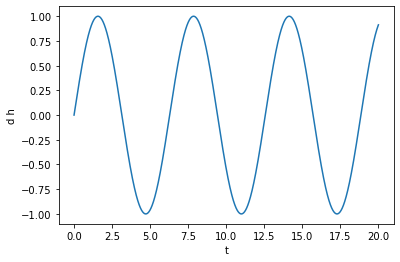

In [4]:
def plot(ser, lab1="d h", lab2="t", *args, **kwargs):
    """Plot Series ser with labels"""
    plt.ylabel(lab1)
    plt.xlabel(lab2)
    plt.plot(ser, *args, **kwargs)
    
plot(gw)

Let's make this more interesting: we square the signal and add Gaussian noise. [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) support directly using all the basic mathematical operations in Python and NumPy, so we can easily square the signal and add another TimeSeries to it.

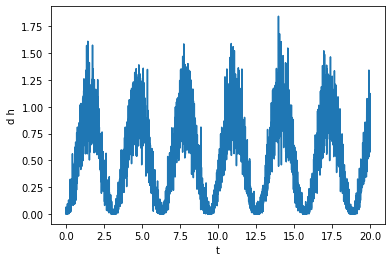

In [5]:
noise = np.random.normal(0, 0.1, len(gw))  # Here we used len() on the TimeSeries
noise_ts = ts.TimeSeries(t, noise)

gw += noise_ts
gw **= 2

plot(gw)

To analyze this signal, first we will smooth it. To do that, we will use the [savgol_smooth_time](../timeseries_ref.html#kuibit.timeseries.TimeSeries.savgol_smooth_time) method, which is a generalized "running average" filter. This method requires length of time over which we want to smooth the data.

In [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) there are always two different methods to do the same task, one with imperative verb (e.g., smooth), and the other with the past tense (e.g., smoothed). The first modifies the data, the second returns a new `TimeSeries` with the operation applied. Here, we will find what smoothing length to use by trial and error, so we will use the second method. 

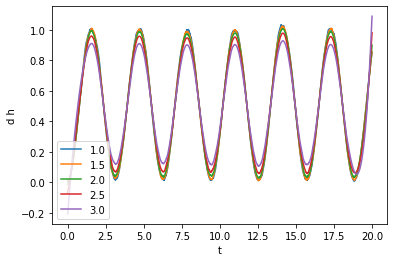

In [6]:
tsmooth = np.linspace(1, 3, 5)

for tsm in tsmooth:
    smoothed = gw.savgol_smoothed_time(tsm)
    plot(smoothed, label=tsm)
plt.legend()

From visual inspection it looks like that ``tsmooth = 1.5`` will work yield a clean series faithful to the original one.

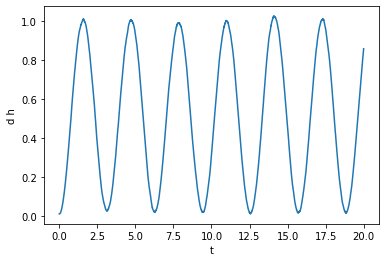

In [7]:
gw.savgol_smooth_time(1.5)
plot(gw)

Next, for fun, we can compute integrals and derivatives. For instance, we can compute what is the integral from 5 to 10.

The integral from 5 to 10 is 2.2047


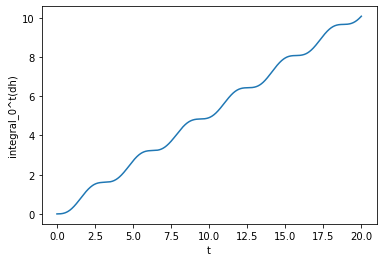

In [8]:
gw_int = gw.integrated()
a = 5
b = 10
print(f"The integral from {a} to {b} is {gw_int(b) - gw_int(a):.4f}")
plot(gw_int, lab1="integral_0^t(dh)")

Here, we showed a very powerful feature of `TimeSeries`: you can call them on a specific time (as we did we ``gw_int(b)``). This is done using splines to interpolate to the points that are not available. Splines can also be used to take derivatives. Alternatively, one can simply take the finite (central) difference. Let's see what's the derivative of ``gw`` using splines and finite difference.

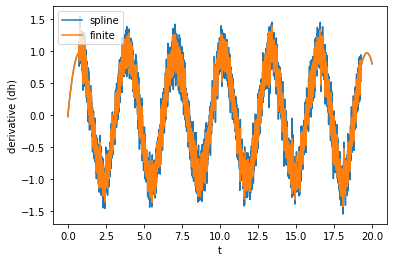

In [9]:
gw_spline_der = gw.spline_differentiated()
gw_numer_der = gw.differentiated()

plot(gw_spline_der, label='spline')
plot(gw_numer_der, lab1="derivative (dh)", label='finite')
plt.legend()

Clearly, derivatives will be noisier than the actual data, so often it is convenient to smooth them out as shown before.

TimeSeries support complex signals. Now, we will create one using `gw` itself. We will copy `gw`, time-shift it, find the common time interval with the original `gw`, and use that as a the imaginary part.

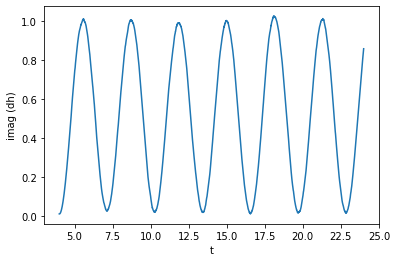

In [10]:
gw_imag = gw.copy()  # It is important to deep copy the object
gw_imag.time_shift(4)

plot(gw_imag, lab1 ="imag (dh)")

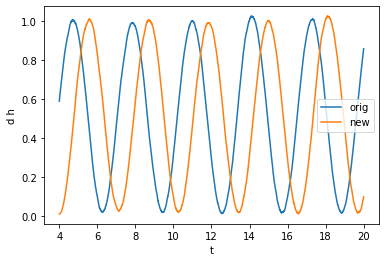

In [11]:
gw, gw_imag = series.sample_common([gw, gw_imag], resample=True)  # Resampling to common times

plot(gw, label="orig")
plot(gw_imag, label="new")
plt.legend()

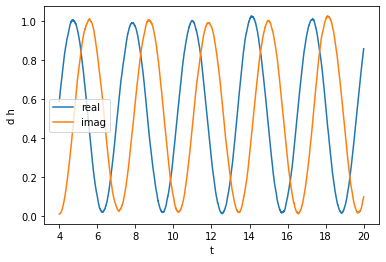

In [12]:
gw_complex = ts.TimeSeries(gw.t, gw.y + 1j * gw_imag.y)

plot(gw_complex.real(), label="real")
plot(gw_complex.imag(), label="imag")
plt.legend()

We can also compute the phase and absolute value. In particular, we will compute the unfolded phase (no wrapping over $2\pi$)

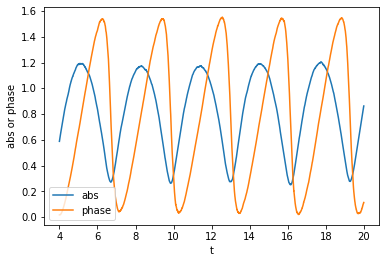

In [13]:
plot(gw_complex.abs(), label='abs')
plot(gw_complex.unfolded_phase(), lab1="abs or phase", label='phase')
plt.legend()

Here, the unfolded phase looks a little bit unusual. This is because we made up the signal.

We can also compute the frequency of the phase, which we can directly smooth.

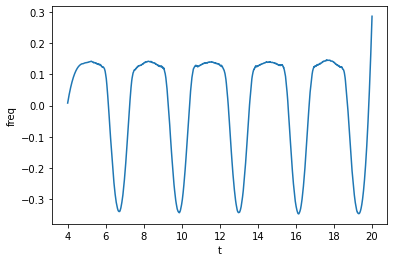

In [14]:
plot(gw_complex.phase_frequency(tsmooth=1.5), lab1="freq")

Next, we will take a Fourier transform. Before, let's pretend that the signal was in geometrized units (as in simulations), and let's make it physical assuming a scale of $M = 1 M_\odot$. For that, use the [unitconv](../unitconv.rst) module. We define a CU object that knows how to convert units.

In [15]:
CU = uc.geom_umass_msun(1) 

# How to convert from geometrized length to physical length?
# Simply multiply times CU.length. Let's check that it is 1.477 km
CU.length  # m

1476.6436994724972

Now we rescale `gw`, assuming that `y` is strain times distance (as usually is). Let's assume a distance of 500 Mpc.

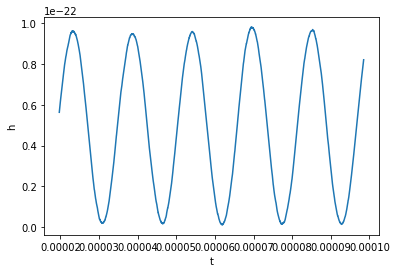

In [16]:
d_Mpc = 500

# inverse = True means from geometrized to physical
gw_physical = gw_complex.time_unit_changed(CU.time, inverse=True)  

gw_physical *= CU.length  # dh -> dh physical
# Now just the strain, since we assume a distance
gw_physical /= (d_Mpc * uc.MEGAPARSEC_SI)

# We have to manually add the redshift
gw_physical.redshifted(luminosity_distance_to_redshift(d_Mpc))

plot(gw_physical.real(), lab1="h")

Okay, now before taking the Fourier transform, we will remove the mean and window our signal. A Tukey window will work.

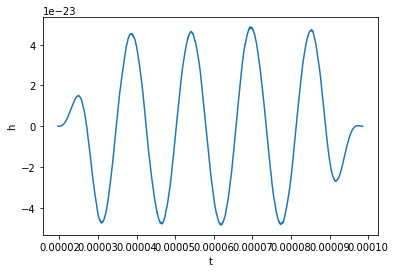

In [17]:
gw_physical.mean_remove()
gw_physical.tukey_window(0.3)
plot(gw_physical.real(), lab1="h")

Finally, we can take the Fourier transform. This is easy to do:

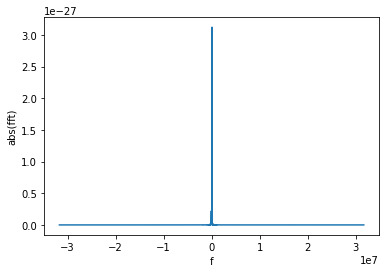

In [18]:
gw_fft = gw_physical.to_FrequencySeries()

# Plotting the amplitude of the Fourier transform
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

The new object is a `FrequencySeries`. It is very similar to a `TimeSeries` and it shares several properties, methods, and features. 

Let's restrict to only positive frequencies close to zero.

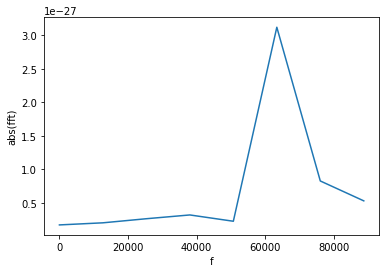

In [19]:
gw_fft.crop(0, 1e5)
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

We can find the frequency of that peak! For this, we find all the peaks with amplitude larger than 1e-27.

Frequency: 64166.71


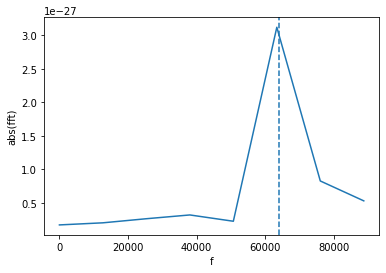

In [20]:
f_peak = gw_fft.peaks_frequencies(1e-27)[0]

print(f"Frequency: {f_peak:.2f}")
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")
plt.axvline(f_peak, ls = 'dashed')

The line is not on the maximum because we use a quadratic interpolation to find a more accurate location of the peak.

Sometimes, it is useful to ignore some data (or example, when we know that the data is invalid). `Series` objects support _masks_ to mark the points we want to ignore. Most functions work transparently with masks: for example, if you ask for the mean of a `Series`, the masked point will be ignored. Other functions do not support masks (most notably, splines). In that case, it is best to completely remove the masked points and work with clean data.

In [21]:
# Let's mask all the point in the spectrum with value larger than 1e-27

spectrum = gw_fft.abs()

print(f"Maximum without mask {spectrum.max():.3e}")

# Apply mask
spectrum.mask_greater(1e-27)

print(f"Maximum with mask {spectrum.max():.3e}")

print(f"Length with mask {len(spectrum)}")

# Remove points
spectrum.mask_remove()

print(f"Length after having removed the masked points {len(spectrum)}")

Maximum without mask 3.120e-27
Maximum with mask 8.291e-28
Length with mask 8
Length after having removed the masked points 7
